In [65]:
from scnn.bipolar_functions.operations import *
from scnn.convertors.sng import *
import numpy as np
import matplotlib.pyplot as plt

In [66]:
seq_len = 16384
f2s = F2S(seq_len=seq_len)
s2f = S2F()

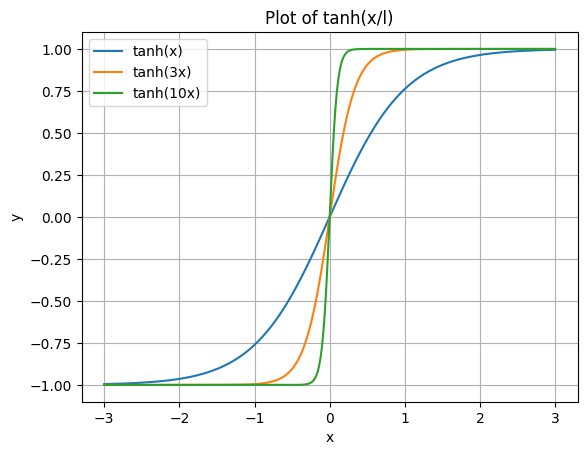

In [70]:


# Define the range of x values
x = np.linspace(-3, 3, 1000)

# Compute the tanh function for each x value
y = np.tanh(x)
# Plot the tanh function
plt.plot(x, y, label='tanh(x)')
# Compute the tanh function for each x value
y = np.tanh(3*x)
# Plot the tanh function
plt.plot(x, y, label='tanh(3x)')
y = np.tanh(10*x)
# Plot the tanh function
plt.plot(x, y, label='tanh(10x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of tanh(x/l)')
plt.grid(True)
plt.legend()


In [4]:
def sc_tanh(inputs, scalar: int):
    in_features, seq_len = inputs.shape[-2], inputs.shape[-1]
    
    v = s_counter(in_features=in_features, num_au_layers=1)(inputs)
    v = v.sum(dim=-1)/seq_len * 2 - in_features

    return torch.tanh(scalar*v)

In [5]:
def sc_btanh(inputs, r: int):
    in_features, seq_len = inputs.shape[-2], inputs.shape[-1]
    s_max = r-1
    s_half = (r-1)/2


    s = torch.full(inputs.shape[:-2], s_half, dtype=torch.int16)
    v = s_counter(in_features=in_features, num_au_layers=1)(inputs)*2 - in_features

    permuted_indices = torch.randperm(v.size(-1))

    v = v[permuted_indices]

    out = torch.zeros(inputs.shape[:-2]+(seq_len,), dtype=torch.bool)

    for i in range(seq_len):
        s = s + v[...,i]
        overflow_idx = s > s_max
        underflow_idx = s < 0
        s[overflow_idx] = s_max
        s[underflow_idx] = 0
        out[..., i] = s > s_half
    return out

In [6]:
def apc_tanh(inputs, scalar):
    in_features, seq_len = inputs.shape[-2], inputs.shape[-1]
    
    v = ap_counter(in_features=in_features, num_au_layers=1)(inputs)
    v = v.sum(dim=-1)/seq_len * 2 - in_features

    return torch.tanh(scalar*v)

In [38]:
def apc_btanh(inputs, r: int):
    in_features, seq_len = inputs.shape[-2], inputs.shape[-1]
    s_max = r-1
    s_half = (r-1)/2


    s = torch.full(inputs.shape[:-2], s_half, dtype=torch.int16)
    v = ap_counter(in_features=in_features, num_au_layers=1)(inputs)*2 - in_features

    permuted_indices = torch.randperm(v.size(-1))

    v = v[permuted_indices]

    out = torch.zeros(inputs.shape[:-2]+(seq_len,), dtype=torch.bool)

    for i in range(seq_len):
        s = s + v[...,i]
        overflow_idx = s > s_max
        underflow_idx = s < 0
        s[overflow_idx] = s_max
        s[underflow_idx] = 0
        out[..., i] = s > s_half
    return out

In [39]:
def c_btanh(inputs, r: int):
    in_features, seq_len = inputs.shape[-2], inputs.shape[-1]
    s_max = r-1
    s_half = (r-1)/2


    s = torch.full(inputs.shape[:-2], s_half, dtype=torch.int16)
    v = inputs.sum(dim=-2)*2 - in_features

    out = torch.zeros(inputs.shape[:-2]+(seq_len,), dtype=torch.bool)

    for i in range(seq_len):
        s = s + v[...,i]
        overflow_idx = s > s_max
        underflow_idx = s < 0
        s[overflow_idx] = s_max
        s[underflow_idx] = 0
        out[..., i] = s > s_half
    return out

In [40]:
def ground_tanh(inputs, scalar):
    in_features = inputs.shape[0]
    seq_len = inputs.shape[-1]
    x = inputs.sum(dim=-1)/seq_len * 2 - 1
    return torch.tanh(scalar * torch.sum(x))

In [41]:
apc = ap_counter(100)

In [64]:
inputs = f2s((torch.rand(100,)*2-1)/4)
inputs_n = s2f(inputs)

# simulated = sc_btanh(inputs, 80)
# print('sc_btanh',s2f(simulated))

simulated = apc_btanh(inputs, 200)
print('apc_btanh',s2f(simulated))


# simulated = c_btanh(inputs, 80)
# print('c_btanh',s2f(simulated))

# simulated = sc_tanh(inputs, 0.45)
# print('sc_tanh',simulated)

# simulated = apc_tanh(inputs, 0.45)
# print('apc_tanh',simulated)

print('ground',ground_tanh(inputs,scalar=1))

# print('xx:', (apc(inputs)-inputs.sum(dim=-2)).sum()/inputs.shape[-1])


apc_btanh tensor(-0.2986)
ground tensor(-0.4178)


In [59]:
inputs = f2s((torch.rand(100,)*2-1)/4)
(apc(inputs)-inputs.sum(dim=-2))[0:16384].max()

tensor(13)

In [32]:
inputs.sum(dim=-2)[0:100]

tensor([54, 53, 57, 52, 46, 52, 54, 50, 45, 44, 53, 55, 47, 58, 43, 56, 62, 46,
        44, 50, 47, 50, 51, 48, 48, 52, 55, 45, 43, 56, 49, 48, 45, 40, 41, 49,
        43, 42, 57, 51, 45, 56, 54, 55, 50, 47, 50, 56, 50, 55, 51, 49, 49, 54,
        49, 53, 39, 51, 50, 47, 50, 53, 55, 46, 47, 53, 52, 52, 47, 46, 53, 48,
        43, 50, 51, 49, 49, 45, 50, 49, 47, 54, 42, 50, 56, 61, 51, 50, 54, 58,
        52, 48, 52, 49, 46, 51, 63, 48, 54, 46])

In [45]:
def get_btanh_states(in_features, scalar):
    q = 1.835*(2*in_features)**(-0.5552)
    r_prime = 2*in_features + 2*(scalar-1)*(in_features-1)/(1-q)
    return int(round(r_prime/2.)*2)

In [57]:
get_btanh_scalar(100,200)

1.0